In [ ]:
# downlading flickr 8k dataset
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d adityajn105/flickr8k

Saving kaggle.json to kaggle.json
ref                                                        title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                    Most Streamed Spotify Songs 2023                 47KB  2023-08-26 11:04:57          18022        565  1.0              
sujaykapadnis/horror-movies-dataset                        Horror Movies dataset                             6MB  2023-09-23 18:26:49            854         39  1.0              
joebeachcapital/students-performance                       Students Performance                              2KB  2023-08-31 00:50:11           6432        160  1.0              
carlmcbrideellis/zzzs-lightweight-training-dataset-target  Zzzs: Lightw

In [ ]:
# extracting images from flickr8k.zip file
!unzip flickr8k.zip

In [ ]:
# importing libraries
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import Model,Input, layers,models
from tensorflow.keras.preprocessing import image,text
import os
# to view loop as a progress bar
from tqdm import tqdm

In [ ]:
# loading VGG16 model
img_model = VGG16()
# removing last layer because we will be adding our own layer
img_model = Model(inputs=img_model.inputs,outputs=img_model.layers[-2].output)

In [ ]:
# to view model summary (parameters,layers and other details)
print(img_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# dictionary to store image_id(img_name) and extracted feature as key value pair, extracted features are numpy array
# eg: 656f6dad5f223: [0,6556,56,65,6,230,89]
img_features = {}
img_dir = '/content/Images'
for img_name in tqdm(os.listdir(img_dir)):
  # getting proper image file path
  img_path = os.path.join(img_dir,img_name)
  # loading image with target_size 224px x 224px because vgg16 by default accepts 224x224 size
  img = image.load_img(img_path,target_size=(224,224))
  # converting iamge to numpy array for processing
  img = image.img_to_array(img)
  # changing image array to shape desired by vgg16 (2D matrix -> 1D array aka Flattening process)
  img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
  # preprocessing image(array) like normalization (converting each pixel between 0 to 1) and other things
  img = preprocess_input(img)
  # passing image into vgg16 model and storing extracted features into dictionary, verbose=0, 0 means do not display progress
  features = img_model.predict(img,verbose=0)
  # storing image name without extension
  img_id = img_name.split('.')[0]
  # storing image features in dictionary
  img_features[img_id] = features


100%|██████████| 8091/8091 [10:13<00:00, 13.19it/s]


In [ ]:
import pickle

In [ ]:
# storing img_features dictionary to a pkl for reusablility
with open('img_features.pkl','wb') as img_feat_file:
  pickle.dump(img_features,img_feat_file)

In [ ]:
# loading img_feaures from pkl file
img_features = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/img_features.pkl','rb'))

In [ ]:
# loading captions text file for preprocessing
with open('/content/captions.txt','r') as file:
  # to skip first line
  next(file)
  # to load entire text file
  caption_txt = file.read()

In [ ]:
# Initialize an empty dictionary to store image captions
image_caption_map = {}
# Loop through each line in the 'caption_txt' string, which presumably contains caption data
for line in tqdm(caption_txt.split('\n')):
    # Split the line into tokens using ',' as the delimiter
    tokens = line.split(',')
    # Check if the line has fewer than 2 tokens (likely an empty or incomplete line), and skip it
    if len(line) < 2:
        continue
    # Extract the image name (first token) and the caption (remaining tokens)
    img_name, caption = tokens[0], tokens[1:]
        # Remove the file extension from the image name (assuming it's a common image file format)
    img_name = img_name.split('.')[0]
    # Join the caption tokens back together into a single string
    caption = ' '.join(caption)
    # Check if the image name is not already in the dictionary; if not, initialize it with an empty list
    if img_name not in image_caption_map:
        image_caption_map[img_name] = []
    # Append the caption to the list of captions for the image
    image_caption_map[img_name].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 635264.12it/s]


In [ ]:
# Function to clean and process captions in the 'image_caption_map' dictionary
def clean_captions(image_caption_map):
    for img_id, captions in image_caption_map.items():
        for i in range(len(captions)):
            # Convert the caption to lowercase
            processed_caption = captions[i].lower()
            # Remove non-alphabet characters
            processed_caption = processed_caption.replace('[^a-z]', '')
            # Remove extra white spaces
            processed_caption = processed_caption.replace('\s+', '')
            # Remove double quotation marks
            processed_caption = processed_caption.replace('"', '')
            # Add '<start>' and '<end>' tokens and remove single characters
            processed_caption = '<start> ' + ' '.join([char for char in processed_caption.split() if len(char) > 1]) + ' <end>'
            # Update the original caption with the processed one
            captions[i] = processed_caption


In [ ]:
clean_captions(image_caption_map)

In [ ]:
# Serialize and save the 'image_caption_map' dictionary to a binary file using pickle
with open('img_caption_map.pkl', 'wb') as img_cap_file:
    pickle.dump(image_caption_map, img_cap_file)

In [ ]:
# Load the 'image_caption_map' dictionary from a binary file using pickle
image_caption_map = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/img_caption_map.pkl', 'rb'))

In [ ]:
# viewing result
image_caption_map['2073964624_52da3a0fc4']

['<start> woman in pink hat and navy blue coat riding bicycle <end>',
 '<start> woman wearing pink cap riding bicycle <end>',
 '<start> woman wearing black clothes purple scarf and pink hat is riding bike <end>',
 '<start> woman with glasses and pink hat rides her bike <end>',
 '<start> the woman is wearing pink hat and is riding bike in the park <end>']

In [ ]:
# Initialize an empty list to collect all captions
all_captions = []
# Iterate through image_caption_map to gather all captions
for img_id, captions in image_caption_map.items():
    # Extend the all_captions list with the captions for this image
    all_captions.extend(captions)

In [ ]:
# Create a text tokenizer
tokenizer = text.Tokenizer()
# Fit the tokenizer on all captions to build the vocabulary
tokenizer.fit_on_texts(all_captions)
# Calculate the vocabulary size, accounting for an additional index for out-of-vocabulary words
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
print(vocab_size)

8483


In [ ]:
# to get maximum available caption in entire caption list
max_caption_len = max(len(caption.split()) for caption in all_captions)

In [ ]:
print(max_caption_len)

34


In [ ]:
# Get a list of image IDs from the keys of the image_caption_map dictionary
img_ids = list(image_caption_map.keys())
# Calculate the split point for train and test sets (90% train, 10% test)
split = int(len(img_ids) * 0.90)
# Create a list of image IDs for the training set (first 90%)
train = img_ids[:split]
# Create a list of image IDs for the test set (last 10%)
test = img_ids[split:]

In [ ]:
print(len(train))
print(len(test))

7281
810


In [ ]:
import numpy as np
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

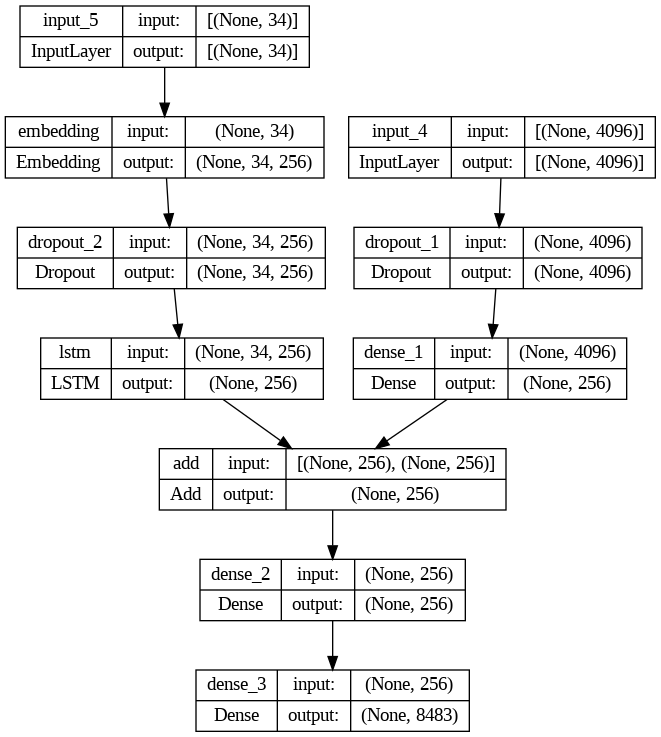

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_caption_len,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, image_caption_map, img_features, tokenizer, max_caption_len, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

119/227 [==============>...............] - ETA: 30s - loss: 2.5250

In [ ]:
def data_generator(data_keys, image_caption_map, img_features, tokenizer, max_caption_len, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    size = 0
    while True:
        for key in data_keys:
            size += 1
            captions = image_caption_map[key]
            for caption in captions:
                # Convert caption to a sequence of integers using the tokenizer
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad the input sequence to the max_caption_len
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_len)[0]
                    # Convert the output sequence to one-hot encoding
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # Append the data to their respective lists
                    X1.append(img_features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
        # Check if the batch size has been reached
        if size == batch_size:
            X1, X2, y = np.array(X1), np.array(X2), np.array(y)
            yield [X1, X2], y
            # Reset the lists and size for the next batch
            X1, X2, y = list(), list(), list()
            size = 0

In [ ]:
# Define the input layer for image features (4096-dimensional vector)
inputs1 = Input(shape=(4096,))
# Apply dropout to the image features
fe1 = layers.Dropout(0.4)(inputs1)
# Add a dense layer with ReLU activation for feature extraction
fe2 = layers.Dense(256, activation='relu')(fe1)

In [ ]:
# Define the input layer for text data (variable length sequences)
inputs2 = Input(shape=(max_caption_len,))
# Apply embedding layer with mask_zero=True to handle variable length sequences
se1 = layers.Embedding(vocab_size, 256, mask_zero=True)(inputs2)
# Apply dropout to the embedded sequences
se2 = layers.Dropout(0.4)(se1)
# Apply an LSTM layer to process the sequential data
se3 = layers.LSTM(256)(se2)

In [ ]:
# Combine the extracted image features and the LSTM output
decoder1 = layers.add([fe2, se3])
# Add another dense layer with ReLU activation
decoder2 = layers.Dense(256, activation='relu')(decoder1)
# Generate the output probabilities for the vocabulary
outputs = layers.Dense(vocab_size, activation='softmax')(decoder2)

In [ ]:
# Create the model with specified inputs and outputs
endec_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# Compile the model with categorical cross-entropy loss and the Adam optimizer
endec_model.compile(loss='categorical_crossentropy', optimizer='adam')

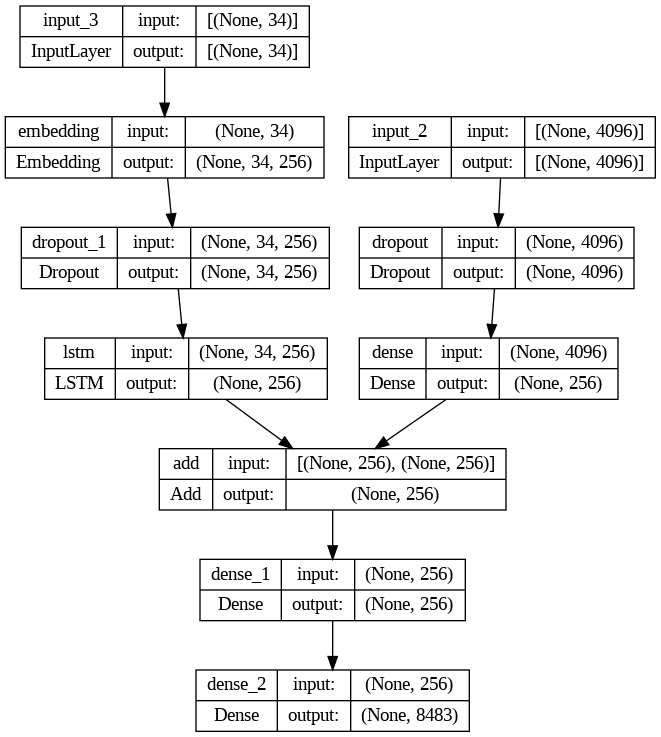

In [ ]:
# Plot the architecture of the 'endec_model' with shapes displayed
plot_model(endec_model, show_shapes=True)

In [ ]:
# Set the number of training epochs and batch size
epochs = 15
batch_size = 16
# Calculate the number of steps per epoch based on the training data size and batch size
step = len(train) // batch_size
# Iterate through the specified number of epochs for training
for i in range(epochs):
    # Create a data generator using the training data
    generator = data_generator(train, image_caption_map, img_features, tokenizer, max_caption_len, vocab_size, batch_size)
    # Train the 'endec_model' for one epoch with the generator
    endec_model.fit(generator, epochs=1, steps_per_epoch=step, verbose=1)
